In [1]:
import os
import numpy as np
import random

import matplotlib.pyplot as plt

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense
from keras.models import Model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Getting the dataset with 200 images belonging to two classes: with and without a face mask.

Original dataset available at: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset

In [ ]:
!echo "Unzip file:"
!unzip with_or_without_mask.zip
!rm with_or_without_mask.zip
!ls

In [3]:
root = 'with_or_without_mask'
categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['with_or_without_mask/with_mask', 'with_or_without_mask/without_mask']


In [4]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [5]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

Defining the training, validation, and testing datasets.

In [6]:
random.shuffle(data)

train_split, val_split = 0.7, 0.15

idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))

train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

In [7]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
# A one-hot vector is a way to represent categorical data as numerical vectors. A one-hot vector is created for each unique category. Example:
# with_mask    = [1, 0]
# without_mask = [0, 1]
num_classes = len(categories)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_test.shape)

(30, 2)


Using transfer learning technique for model classification.

The transfer learning algorithm is based on the code available at:  https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb

In [8]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


In [9]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
history = model_new.fit(x_train, y_train,
                         batch_size=16,
                         epochs=5,
                         validation_data=(x_val, y_val))

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4809 - loss: 0.9831 - val_accuracy: 0.6000 - val_loss: 0.5249
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.6786 - loss: 0.4886 - val_accuracy: 0.9000 - val_loss: 0.3621
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8475 - loss: 0.3392 - val_accuracy: 0.9000 - val_loss: 0.2798
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9212 - loss: 0.2430 - val_accuracy: 0.9333 - val_loss: 0.2342
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.8713 - loss: 0.2478 - val_accuracy: 0.9667 - val_loss: 0.1968


Checks if the model's prediction aligns with the actual labels of the test dataset.

In [11]:
y_pred_probs = model_new.predict(x_test) # Creates an array of prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1) # Gets the index of the class with the highest probability

# The test label set (y_test) is in one-hot encoded format,
# but scikit-learn metric functions generally expect labels in index format (e.g., 0 for class 0 and 1 for class 1).
# This line converts the test labels back to index format.
y_test_labels = np.argmax(y_test, axis=1)

print("True labels in test dataset: ", y_test_labels)
print("Model predictions: ", y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
True labels in test dataset:  [0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1 0]
Model predictions:  [0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1]


Plot the confusion matrix.

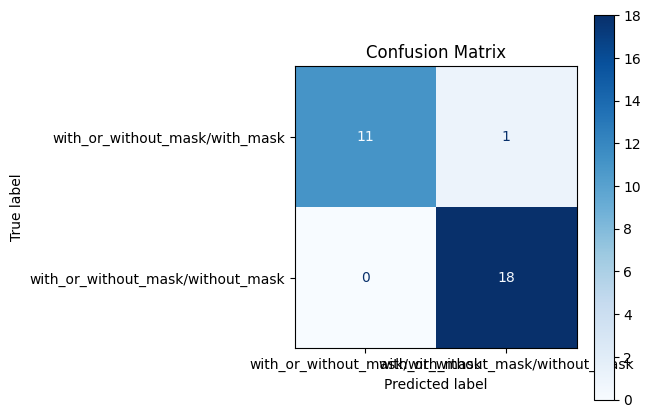

In [15]:
cm = confusion_matrix(y_test_labels, y_pred, labels=np.arange(num_classes))

# To display the confusion matrix in a visually appealing way
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

## Precision:
Precision measures the accuracy of positive predictions. It answers the question: "Of all the instances that the model predicted as positive for a certain class, how many were actually positive for that class?"

Precision = TP/(TP+FP)



## Recall (Sensitivity):
Recall measures the ability of the model to find all the relevant cases (positive instances). It answers the question: "Of all the actual positive instances for a certain class, how many did the model correctly identify?"

Recall = TP/(TP+FN)



## F1-Score:
The F1-Score is the harmonic mean of Precision and Recall. It provides a single metric that balances both. It answers the question: "What is the balance between precision and recall?"

F-score = 2 * (Precision * Recall) / (Precision + Recall)



## Support:
Support is the number of actual occurrences of a specific class in the dataset. It indicates the frequency of each class.


In [16]:
print(classification_report(y_test_labels, y_pred, labels=np.arange(num_classes), target_names=categories))

                                   precision    recall  f1-score   support

   with_or_without_mask/with_mask       1.00      0.92      0.96        12
with_or_without_mask/without_mask       0.95      1.00      0.97        18

                         accuracy                           0.97        30
                        macro avg       0.97      0.96      0.96        30
                     weighted avg       0.97      0.97      0.97        30

